In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
 
from datetime import datetime,timedelta
import datetime as dt
from sklearn.metrics import classification_report


In [ ]:
url = 'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/atp_data.csv'
data = pd.read_csv(url)


# **CODE PROPRE**

In [ ]:
data.head(3)

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,Wsets,Lsets,Comment,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo
0,1,Adelaide,Australian Hardcourt Championships,2000-01-03,International,Outdoor,Hard,1st Round,3,Dosedel S.,Ljubicic I.,63,77,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
1,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Kiefer N.,Tarango J.,6,59,2.0,0.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5
2,3,Doha,Qatar Open,2000-01-03,International,Outdoor,Hard,1st Round,3,Gaudio G.,Luxa P.,73,174,2.0,1.0,Completed,NaN,NaN,NaN,NaN,1500.0,1500.0,0.5


## **Data Pre-processing**

#### Timeframe selection

In [ ]:
# Given there are some duplicated lines in 2012 and data stop between 2013-11-11 to 2014-01-05, we'll start the analysis from 2015.

# Data selection

data['Date'] = pd.to_datetime(data.Date)

beg=datetime(2015,1,1) 
end=datetime(2019,1,1)

indices=data[(data.Date>beg)&(data.Date<=end)].index
data=data.iloc[indices,:]

print("Number of games since Jan'2015: ",len(data))


Number of games since Jan'2015:  8499


#### Unknown data at game time must be removed

In [ ]:
data.drop(['Wsets','Lsets','proba_elo'],axis=1,inplace=True)


#### ELO ranking temparily removed as they will be recomputed with the data from 2018 

In [ ]:
data.drop(['elo_winner','elo_loser'],axis=1,inplace=True)

#### Add data from 2018

In [ ]:
# DATA uploaded

urls = ['https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2018.csv', 'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2019.csv', 'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2020.csv', 'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/2021.csv']
dfs = [pd.read_csv(url,sep=';') for url in urls]
data2 = pd.concat(dfs, ignore_index=True)

# Keep colums we need

data2.drop(['WPts','LPts','W1','L1','W2','L2','W3','L3','W4','L4','W5','L5','Wsets','Lsets','EXW','EXL','LBW','LBL','MaxW','MaxL','AvgW','AvgL'],axis=1,inplace=True)

#Format adjustment

data2.PSW= (data2.PSW.replace(',','.', regex=True).astype(float))
data2.PSL= (data2.PSL.replace(',','.', regex=True).astype(float))
data2.B365W= (data2.B365W.replace(',','.', regex=True).astype(float))
data2.B365L= (data2.B365L.replace(',','.', regex=True).astype(float)) 




In [ ]:
data2.head(3)

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,Comment,B365W,B365L,PSW,PSL
0,1,Brisbane,Brisbane International,31/12/2017,ATP250,Outdoor,Hard,1st Round,3,Dolgopolov O.,Schwartzman D.,169.0,26.0,Completed,2.20,1.61,2.24,1.71
1,1,Brisbane,Brisbane International,31/12/2017,ATP250,Outdoor,Hard,1st Round,3,De Minaur A.,Johnson S.,209.0,44.0,Completed,2.75,1.40,3.14,1.41
2,1,Brisbane,Brisbane International,01/01/2018,ATP250,Outdoor,Hard,1st Round,3,Harrison R.,Mayer L.,47.0,52.0,Completed,1.61,2.20,1.66,2.35


In [ ]:
# Align 'Data2' columns based on 'Data'

data2 = data2[['ATP', 'Location', 'Tournament', 'Date','Series', 'Court', 'Surface', 'Round','Best of', 'Winner', 'Loser', 'WRank','LRank', 'Comment', 'PSW', 'PSL', 'B365W', 'B365L']]

In [ ]:
# Data selection (remove 2018 data already in Dataframe)

data2['Date'] = pd.to_datetime(data2.Date)

beg=datetime(2018,3,4) 

indices=data2[(data2.Date>beg)].index
data2=data2.iloc[indices,:]

print("Number of games since 04/03: ",len(data2))

Number of games since 04/03:  7183


In [ ]:
# Concatenate Data/Data2

data=pd.concat([data,data2], axis = 0)
data=data.reset_index(drop=True)


In [ ]:
data.head(15)

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,Comment,PSW,PSL,B365W,B365L
0,3,Doha,Qatar Exxon Mobil Open,2015-01-05,ATP250,Outdoor,Hard,1st Round,3,Bolelli S.,Becker B.,52.0,40.0,Completed,2.16,1.76,2.20,1.61
1,3,Doha,Qatar Exxon Mobil Open,2015-01-05,ATP250,Outdoor,Hard,1st Round,3,Dodig I.,Safwat M.,89.0,289.0,Completed,1.17,5.84,1.16,5.00
2,3,Doha,Qatar Exxon Mobil Open,2015-01-05,ATP250,Outdoor,Hard,1st Round,3,Gasquet R.,Andujar P.,26.0,41.0,Completed,1.24,4.44,1.20,4.33
3,3,Doha,Qatar Exxon Mobil Open,2015-01-05,ATP250,Outdoor,Hard,1st Round,3,Brown D.,Lorenzi P.,98.0,63.0,Completed,1.57,2.55,1.53,2.37
4,3,Doha,Qatar Exxon Mobil Open,2015-01-05,ATP250,Outdoor,Hard,1st Round,3,Verdasco F.,Gabashvili T.,33.0,66.0,Completed,1.42,3.09,1.40,2.75
5,3,Doha,Qatar Exxon Mobil Open,2015-01-05,ATP250,Outdoor,Hard,1st Round,3,Karlovic I.,Rosol L.,27.0,30.0,Completed,1.53,2.65,1.44,2.62
6,2,Chennai,Chennai Open,2015-01-05,ATP250,Outdoor,Hard,1st Round,3,Muller G.,Roger-Vasselin E.,46.0,116.0,Completed,1.81,2.10,1.66,2.10
7,1,Brisbane,Brisbane International,2015-01-05,ATP250,Outdoor,Hard,1st Round,3,Kokkinakis T.,Benneteau J.,149.0,25.0,Completed,2.67,1.53,2.62,1.44
8,1,Brisbane,Brisbane International,2015-01-05,ATP250,Outdoor,Hard,1st Round,3,Duckworth J.,Simon G.,125.0,21.0,Completed,4.67,1.23,4.50,1.18
9,2,Chennai,Chennai Open,2015-01-05,ATP250,Outdoor,Hard,1st Round,3,Haider-Maurer A.,Granollers M.,79.0,55.0,Retired,2.76,1.50,2.75,1.40


#### ELO ranking calculation

In [ ]:

def compute_elo_rankings(data):
    """
    Given the list on matches in chronological order, for each match, computes 
    the elo ranking of the 2 players at the beginning of the match
    
    """
    print("Elo rankings computing...")
    players=list(pd.Series(list(data.Winner)+list(data.Loser)).value_counts().index)
    elo=pd.Series(np.ones(len(players))*1500,index=players)
    ranking_elo=[(1500,1500)]
    for i in range(1,len(data)):
        w=data.iloc[i-1,:].Winner
        l=data.iloc[i-1,:].Loser
        elow=elo[w]
        elol=elo[l]
        pwin=1 / (1 + 10 ** ((elol - elow) / 400))    
        K_win=32
        K_los=32
        new_elow=elow+K_win*(1-pwin)
        new_elol=elol-K_los*(1-pwin)
        elo[w]=new_elow
        elo[l]=new_elol
        ranking_elo.append((elo[data.iloc[i,:].Winner],elo[data.iloc[i,:].Loser])) 
        if i%5000==0:
            print(str(i)+" matches computed...")
    ranking_elo=pd.DataFrame(ranking_elo,columns=["elo_winner","elo_loser"]) 
    ranking_elo["p_elo_winner"]=1 / (1 + 10 ** ((ranking_elo["elo_loser"] - ranking_elo["elo_winner"]) / 400))   
    ranking_elo["p_elo_loser"]=1 / (1 + 10 ** ((ranking_elo["elo_winner"] - ranking_elo["elo_loser"]) / 400))   
    return ranking_elo

# Computing of the elo ranking of each player at the beginning of each match.
elo_rankings = compute_elo_rankings(data)
data = pd.concat([data,elo_rankings],1)

Elo rankings computing...
5000 matches computed...
10000 matches computed...
15000 matches computed...


#### Remove outliers / absurd values

In [ ]:
# Only use normal completed games

data = data[data.Comment == 'Completed']
data.drop('Comment',axis=1,inplace=True)

# Remove Round Robin tournaments as they interfere with some cumulative stats calculations

data = data[data.Round != 'Round Robin']

# Odds need to be > 1

data = data[(data.PSW >1)&(data.PSL>1)&(data.B365W>1)&(data.B365W>1)]

# ATP rankings cannot be 0

data = data[(data.WRank != 0) & (data.LRank != 0)]

# Remove remaining NaNs

data.dropna(axis=0,inplace=True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14930 entries, 0 to 15681
Data columns (total 21 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   ATP           14930 non-null  int64         
 1   Location      14930 non-null  object        
 2   Tournament    14930 non-null  object        
 3   Date          14930 non-null  datetime64[ns]
 4   Series        14930 non-null  object        
 5   Court         14930 non-null  object        
 6   Surface       14930 non-null  object        
 7   Round         14930 non-null  object        
 8   Best of       14930 non-null  int64         
 9   Winner        14930 non-null  object        
 10  Loser         14930 non-null  object        
 11  WRank         14930 non-null  float64       
 12  LRank         14930 non-null  float64       
 13  PSW           14930 non-null  float64       
 14  PSL           14930 non-null  float64       
 15  B365W         14930 non-null  float6

In [ ]:
data.head()

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,PSW,PSL,B365W,B365L,elo_winner,elo_loser,p_elo_winner,p_elo_loser
0,3,Doha,Qatar Exxon Mobil Open,2015-01-05,ATP250,Outdoor,Hard,1st Round,3,Bolelli S.,Becker B.,52.0,40.0,2.16,1.76,2.20,1.61,1500.0,1500.0,0.5,0.5
1,3,Doha,Qatar Exxon Mobil Open,2015-01-05,ATP250,Outdoor,Hard,1st Round,3,Dodig I.,Safwat M.,89.0,289.0,1.17,5.84,1.16,5.00,1500.0,1500.0,0.5,0.5
2,3,Doha,Qatar Exxon Mobil Open,2015-01-05,ATP250,Outdoor,Hard,1st Round,3,Gasquet R.,Andujar P.,26.0,41.0,1.24,4.44,1.20,4.33,1500.0,1500.0,0.5,0.5
3,3,Doha,Qatar Exxon Mobil Open,2015-01-05,ATP250,Outdoor,Hard,1st Round,3,Brown D.,Lorenzi P.,98.0,63.0,1.57,2.55,1.53,2.37,1500.0,1500.0,0.5,0.5
4,3,Doha,Qatar Exxon Mobil Open,2015-01-05,ATP250,Outdoor,Hard,1st Round,3,Verdasco F.,Gabashvili T.,33.0,66.0,1.42,3.09,1.40,2.75,1500.0,1500.0,0.5,0.5


#### Create cumulative stats 



In [ ]:
# Player dataset preparation

# Step 1 -> Copy Data and add a counter for victorie and defeats

data.reset_index(inplace=True)

df1 = data.copy()
df1['w']=1
df1['l']=0

# step 2 -> Select and concatenate the columns we need

index=df1['index']
winner=df1['Winner']
loser=df1['Loser']
surface=df1['Surface']
w=df1['w']
l=df1['l']
date=df1['Date']

df2 = pd.concat([index,winner,loser,surface,w,l,date], axis = 1)

df2.head()

,index,Winner,Loser,Surface,w,l,Date
0,0,Bolelli S.,Becker B.,Hard,1,0,2015-01-05
1,1,Dodig I.,Safwat M.,Hard,1,0,2015-01-05
2,2,Gasquet R.,Andujar P.,Hard,1,0,2015-01-05
3,3,Brown D.,Lorenzi P.,Hard,1,0,2015-01-05
4,4,Verdasco F.,Gabashvili T.,Hard,1,0,2015-01-05


In [ ]:
# step 3 -> Create Player dataframe : create a row for each player (double nb of lines)

player=pd.concat([winner,loser], axis = 0)
status=pd.concat([w,l], axis = 0)
index=pd.concat([index,index], axis = 0)
surface=pd.concat([surface,surface], axis = 0)
date=pd.concat([date,date], axis = 0)

df3 = pd.concat([index,player, status,surface,date], axis = 1)
df3.columns = ['index','Player','Winner','Surface','Date']


In [ ]:
df3.head()


,index,Player,Winner,Surface,Date
0,0,Bolelli S.,1,Hard,2015-01-05
1,1,Dodig I.,1,Hard,2015-01-05
2,2,Gasquet R.,1,Hard,2015-01-05
3,3,Brown D.,1,Hard,2015-01-05
4,4,Verdasco F.,1,Hard,2015-01-05


In [ ]:
# Create 'Shape' indicator based on recent number of games played 

#def forme (row):
  # if ((row['Played_R'] >= 4)):
     # return 1
   #elif ((row['Played_R'] >=3) & (row['Played_R'] < 4) & (row['Win_rate_R'] >= 0.5)):
    #  return 2
  # elif ((row['Played_R'] >=2) & (row['Played_R'] < 3) & (row['Win_rate_R'] > 0.5)):
    #  return 3
   #elif ((row['Played_R'] >=1) & (row['Played_R'] < 2) & (row['Win_rate_R'] > 0.5)):
    #  return 4
   #else:
    #  return 5
    
#data_players['Shape'] = data_players.apply (lambda row: forme(row), axis=1)

In [ ]:
df3.info()
print(df3.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29860 entries, 0 to 14929
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   index    29860 non-null  int64         
 1   Player   29860 non-null  object        
 2   Winner   29860 non-null  int64         
 3   Surface  29860 non-null  object        
 4   Date     29860 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 1.4+ MB
0


#### Collect and merge new data on players (Birthday + Strong hand)

In [ ]:
# New dataframe with players data

#url2 = 'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/Player.csv'
#player = pd.read_csv(url2)

In [ ]:
# Format players name so that they can be merged with data_players

#player['Player'] = player['name'].str.split().str[1:].str.join(" ").add(" "+player['name'].str[0].str[0].add("."))
#player.drop(['player_id','country','name'],axis=1,inplace=True)

# Remove duplicated players and players with no birthday

#player.drop_duplicates(subset='Player',keep='first',inplace=True)
#player.dropna(axis=0,inplace=True)
#player.Player.duplicated().sum()

# Conversion to DateTime

#player['birthday'] = pd.to_datetime(player.birthday)

# Merging Birthday + Strong hand data

#data_players=data_players.merge(right=player,on = "Player",how = "left")

# Replace NaN in 'Strong Hand' with 'U' for 'unidentified

#data_players.hand.fillna('U',inplace=True)

In [ ]:
#data_players.head(10)

In [ ]:
# step 4 -> Pivot table 

df_players = pd.pivot_table(df3,index=['Player','index','Surface','Date'])
df_players.head()

Winner
Player    index Surface Date              
Ahouda A. 3437  Clay    2016-04-05       0
          6062  Clay    2017-04-11       1
          6084  Clay    2017-04-13       0
          8895  Clay    2018-10-04       0
Albot R.  2076  Hard    2015-08-31       0

In [ ]:
# step 5 -> Build Defeats counter where winner = 0.

df_players['Loser']=df_players['Winner'].apply(lambda x: 0 if x ==1 else 1)

In [ ]:
df_players.head()

Winner  Loser
Player    index Surface Date                     
Ahouda A. 3437  Clay    2016-04-05       0      1
          6062  Clay    2017-04-11       1      0
          6084  Clay    2017-04-13       0      1
          8895  Clay    2018-10-04       0      1
Albot R.  2076  Hard    2015-08-31       0      1

In [ ]:
# step 6 -> Sort Players Dataframe by Date (preparation for cumulative variables)

df_players.reset_index(inplace=True)
df_players.set_index(['Date'], inplace=True)
df_players.sort_values(['Date'], inplace=True)

In [ ]:
df_players.head()

,Player,index,Surface,Winner,Loser
Date,,,,,
2015-01-05,Haase R.,12,Hard,0,1
2015-01-05,Becker B.,0,Hard,0,1
2015-01-05,Querrey S.,11,Hard,0,1
2015-01-05,Karlovic I.,5,Hard,1,0
2015-01-05,Benneteau J.,7,Hard,0,1


In [ ]:
# Step 7 : Build cumlative stats

df_surface = df_players.copy()

# step 7a -> Cumulative wins/defeats (Rolling sum on recent days removing game of the day because result still unknown)

df_players['Wins_R']=df_players.groupby('Player')['Winner'].transform(lambda x: x.rolling('3000D').sum()).fillna(0)-df_players['Winner']  # NB days can be changed if needed
df_players['Defeats_R']=df_players.groupby('Player')['Loser'].transform(lambda x: x.rolling('3000D').sum()).fillna(0)-df_players['Loser'] # NB days can be changed if needed
df_players['Played_R']=df_players['Wins_R']+df_players['Defeats_R']
df_players['WinRate_R']=df_players['Wins_R']/df_players['Played_R']
df_players['WinRate_R'].fillna(0,inplace=True)

In [ ]:
# check

df_players[(df_players.Player=='Federer R.')|(df_players.Player=='Federer R.')].head(7)

,Player,index,Surface,Winner,Loser,Wins_R,Defeats_R,Played_R,WinRate_R
Date,,,,,,,,,
2015-01-08,Federer R.,61,Hard,1,0,0,0,0,0.0
2015-01-09,Federer R.,76,Hard,1,0,1,0,1,1.0
2015-01-10,Federer R.,81,Hard,1,0,2,0,2,1.0
2015-01-11,Federer R.,83,Hard,1,0,3,0,3,1.0
2015-01-19,Federer R.,147,Hard,1,0,4,0,4,1.0
2015-01-21,Federer R.,209,Hard,1,0,5,0,5,1.0
2015-01-23,Federer R.,239,Hard,0,1,6,0,6,1.0


In [ ]:
# # step 7b -> Cumulative wins/defeats by surface

df_surface.Surface.value_counts()

Hard     17178
Clay      9592
Grass     3090
Name: Surface, dtype: int64

In [ ]:
df_surface['Wins_R']=df_surface.groupby(['Player','Surface'])['Winner'].transform(lambda x: x.rolling('3000D').sum()).fillna(0)-df_surface['Winner']  # NB days can be changed if needed
df_surface['Defeats_R']=df_surface.groupby(['Player','Surface'])['Loser'].transform(lambda x: x.rolling('3000D').sum()).fillna(0)-df_surface['Loser'] # NB days can be changed if needed
df_surface['Played_R']=df_surface['Wins_R']+df_surface['Defeats_R']
df_surface['WinRate_R']=df_surface['Wins_R']/df_surface['Played_R']
df_surface['WinRate_R'].fillna(0,inplace=True)

In [ ]:
# check

df_surface[(df_players.Player=='Federer R.')|(df_players.Player=='Federer R.')].head()

,Player,index,Surface,Winner,Loser,Wins_R,Defeats_R,Played_R,WinRate_R
Date,,,,,,,,,
2015-01-08,Federer R.,61,Hard,1,0,0,0,0,0.0
2015-01-09,Federer R.,76,Hard,1,0,1,0,1,1.0
2015-01-10,Federer R.,81,Hard,1,0,2,0,2,1.0
2015-01-11,Federer R.,83,Hard,1,0,3,0,3,1.0
2015-01-19,Federer R.,147,Hard,1,0,4,0,4,1.0


In [ ]:
# step 8 Prepare'df_players' and 'df_surface' for merge with Data

# A. Sort Dataframe (same as Data)

df_players.sort_values(['index','Loser'], inplace=True)
df_surface.sort_values(['index','Loser'], inplace=True)

# B. Take every other line of df_Players/df_Surface to reduce the dataframe by half // Data

Players_merge = pd.DataFrame({'Winner':df_players['Player'].iloc[::2].values, 'Loser':df_players['Player'].iloc[1::2].values,
                        'Winner_wins_R':df_players['Wins_R'].iloc[::2].values, 'Loser_wins_R':df_players['Wins_R'].iloc[1::2].values,
                        'Winner_defeats_R':df_players['Defeats_R'].iloc[::2].values, 'Loser_defeats_R':df_players['Defeats_R'].iloc[1::2].values,
                        'Winner_Played_R':df_players['Played_R'].iloc[::2].values, 'Loser_Played_R':df_players['Played_R'].iloc[1::2].values,
                        'Winner_WinRate_R':df_players['WinRate_R'].iloc[::2].values, 'Loser_WinRate_R':df_players['WinRate_R'].iloc[1::2].values,
                        'Winner_wins_S':df_surface['Wins_R'].iloc[::2].values, 'Loser_wins_S':df_surface['Wins_R'].iloc[1::2].values,
                        'Winner_defeats_S':df_surface['Defeats_R'].iloc[::2].values, 'Loser_defeats_S':df_surface['Defeats_R'].iloc[1::2].values,
                        'Winner_Played_S':df_surface['Played_R'].iloc[::2].values, 'Loser_Played_S':df_surface['Played_R'].iloc[1::2].values,
                        'Winner_WinRate_S':df_surface['WinRate_R'].iloc[::2].values, 'Loser_WinRate_S':df_surface['WinRate_R'].iloc[1::2].values,
                        'index':df_players['index'].iloc[1::2].values})

In [ ]:
Players_merge.head()

,Winner,Loser,Winner_wins_R,Loser_wins_R,Winner_defeats_R,Loser_defeats_R,Winner_Played_R,Loser_Played_R,Winner_WinRate_R,Loser_WinRate_R,Winner_wins_S,Loser_wins_S,Winner_defeats_S,Loser_defeats_S,Winner_Played_S,Loser_Played_S,Winner_WinRate_S,Loser_WinRate_S,index
0,Bolelli S.,Becker B.,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,0
1,Dodig I.,Safwat M.,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,1
2,Gasquet R.,Andujar P.,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,2
3,Brown D.,Lorenzi P.,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,3
4,Verdasco F.,Gabashvili T.,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,4


In [ ]:
#Check

Players_merge[(Players_merge.Winner=='Federer R.')|(Players_merge.Loser=='Federer R.')].head()

,Winner,Loser,Winner_wins_R,Loser_wins_R,Winner_defeats_R,Loser_defeats_R,Winner_Played_R,Loser_Played_R,Winner_WinRate_R,Loser_WinRate_R,Winner_wins_S,Loser_wins_S,Winner_defeats_S,Loser_defeats_S,Winner_Played_S,Loser_Played_S,Winner_WinRate_S,Loser_WinRate_S,index
59,Federer R.,Millman J.,0,1,0,0,0,1,0.0,1.0,0,1,0,0,0,1,0.0,1.0,61
74,Federer R.,Duckworth J.,1,2,0,0,1,2,1.0,1.0,1,2,0,0,1,2,1.0,1.0,76
79,Federer R.,Dimitrov G.,2,2,0,0,2,2,1.0,1.0,2,2,0,0,2,2,1.0,1.0,81
81,Federer R.,Raonic M.,3,3,0,0,3,3,1.0,1.0,3,3,0,0,3,3,1.0,1.0,83
143,Federer R.,Lu Y.H.,4,3,0,2,4,5,1.0,0.6,4,3,0,2,4,5,1.0,0.6,147


In [ ]:
# step 9 -> Merging Data with Players on: index, Loser, Winner 

Players_merge.rename(columns={'index': 'index_t', 'Winner': 'Winner_t', 'Loser': 'Loser_t'},inplace=True)
data=pd.concat([data,Players_merge], axis = 1)
data.drop(['index_t','Winner_t','Loser_t'],axis=1,inplace=True)

In [ ]:
#Check

data[(data.Winner=='Becker B.')|(data.Loser=='Becker.B')].head(7)

,index,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,Loser,WRank,LRank,PSW,PSL,B365W,B365L,elo_winner,elo_loser,p_elo_winner,p_elo_loser,Winner_wins_R,Loser_wins_R,Winner_defeats_R,Loser_defeats_R,Winner_Played_R,Loser_Played_R,Winner_WinRate_R,Loser_WinRate_R,Winner_wins_S,Loser_wins_S,Winner_defeats_S,Loser_defeats_S,Winner_Played_S,Loser_Played_S,Winner_WinRate_S,Loser_WinRate_S
174,179,6,Melbourne,Australian Open,2015-01-20,Grand Slam,Outdoor,Hard,1st Round,5,Becker B.,Benneteau J.,41.0,25.0,3.10,1.43,3.00,1.36,1468.000000,1486.236104,0.473780,0.526220,0,1,2,2,2,3,0.000000,0.333333,0,1,2,2,2,3,0.000000,0.333333
214,221,6,Melbourne,Australian Open,2015-01-22,Grand Slam,Outdoor,Hard,2nd Round,5,Becker B.,Hewitt L.,41.0,87.0,1.88,2.02,1.72,2.00,1484.839033,1500.736307,0.477138,0.522862,1,1,2,1,3,2,0.333333,0.500000,1,1,2,1,3,2,0.333333,0.500000
512,534,16,Acapulco,Abierto Mexicano,2015-02-24,ATP500,Outdoor,Hard,1st Round,3,Becker B.,Kamke T.,41.0,97.0,1.56,2.58,1.50,2.50,1470.804870,1475.829131,0.492770,0.507230,2,1,4,3,6,4,0.333333,0.250000,2,1,4,3,6,4,0.333333,0.250000
1202,1261,33,Paris,French Open,2015-05-25,Grand Slam,Outdoor,Clay,1st Round,5,Becker B.,Bemelmans R.,48.0,95.0,1.91,2.00,1.66,2.10,1392.434508,1457.559341,0.407360,0.592640,3,0,11,3,14,3,0.214286,0.000000,0,0,4,1,4,1,0.000000,0.000000
1244,1305,33,Paris,French Open,2015-05-27,Grand Slam,Outdoor,Clay,2nd Round,5,Becker B.,Verdasco F.,48.0,34.0,13.00,1.05,13.00,1.04,1411.398979,1574.361122,0.281287,0.718713,4,15,11,11,15,26,0.266667,0.576923,1,8,4,6,5,14,0.200000,0.571429
2106,2212,54,St. Petersburg,St. Petersburg Open,2015-09-23,ATP250,Indoor,Hard,1st Round,3,Becker B.,Golubev A.,71.0,154.0,2.78,1.49,2.62,1.44,1384.236884,1428.568833,0.436545,0.563455,5,3,17,9,22,12,0.227273,0.250000,3,2,11,6,14,8,0.214286,0.250000
2148,2257,55,Kuala Lumpur,Malaysian Open,2015-09-28,ATP250,Indoor,Hard,1st Round,3,Becker B.,Groth S.,74.0,53.0,2.51,1.58,2.50,1.50,1392.392000,1544.117492,0.294547,0.705453,6,16,18,19,24,35,0.250000,0.457143,4,10,12,12,16,22,0.250000,0.454545


#### Remove Winners / Losers -> Replace with P1 and P2 taken randomly 

In [ ]:
# Values of Player 1 and 2 are taken randomly

# First we create Player 1

v = data[['Winner', 'Loser']].values
ix = np.random.randint(0,v.shape[1],data.shape[0])
data['P1'] = np.take_along_axis(v, ix[:,None], 1)

# Then Player 2 

data['P2'] = np.where(data.P1 == data.Winner,data.Loser, data.Winner)

# We then allocate all the attributes by checking the position of P1/P2 vs Winner/Loser on each line:

data['P1_Rank']=np.where(data.P1 == data.Winner,data.WRank,data.LRank)
data['P2_Rank']=np.where(data.P2 == data.Winner,data.WRank,data.LRank)

data['P1_Elo']=np.where(data.P1 == data.Winner,data.elo_winner,data.elo_loser)
data['P2_Elo']=np.where(data.P2 == data.Winner,data.elo_winner,data.elo_loser)

data['P1_p_Elo']=np.where(data.P1 == data.Winner,data.p_elo_winner,data.p_elo_loser)
data['P2_p_Elo']=np.where(data.P2 == data.Winner,data.p_elo_winner,data.p_elo_loser)

data['P1_Odds_Pin']=np.where(data.P1 == data.Winner,data.PSW,data.PSL)
data['P2_Odds_Pin']=np.where(data.P2 == data.Winner,data.PSW,data.PSL)

data['P1_Odds_B365']=np.where(data.P1 == data.Winner,data.B365W,data.B365L)
data['P2_Odds_B365']=np.where(data.P2 == data.Winner,data.B365W,data.B365L)

data['P1_Wins']=np.where(data.P1 == data.Winner,data.Winner_wins_R,data.Loser_wins_R)
data['P2_Wins']=np.where(data.P2 == data.Winner,data.Winner_wins_R,data.Loser_wins_R)

data['P1_Defeats']=np.where(data.P1 == data.Winner,data.Winner_defeats_R,data.Loser_defeats_R)
data['P2_Defeats']=np.where(data.P2 == data.Winner,data.Winner_defeats_R,data.Loser_defeats_R)

data['P1_Played']=np.where(data.P1 == data.Winner,data.Winner_Played_R,data.Loser_Played_R)
data['P2_Played']=np.where(data.P2 == data.Winner,data.Winner_Played_R,data.Loser_Played_R)

data['P1_WinRate']=np.where(data.P1 == data.Winner,data.Winner_WinRate_R,data.Loser_WinRate_R)
data['P2_WinRate']=np.where(data.P2 == data.Winner,data.Winner_WinRate_R,data.Loser_WinRate_R)

data['P1_Surface_Wins']=np.where(data.P1 == data.Winner,data.Winner_wins_S,data.Loser_wins_S)
data['P2_Surface_Wins']=np.where(data.P2 == data.Winner,data.Winner_wins_S,data.Loser_wins_S)

data['P1_Surface_Defeats']=np.where(data.P1 == data.Winner,data.Winner_defeats_S,data.Loser_defeats_S)
data['P2_Surface_Defeats']=np.where(data.P2 == data.Winner,data.Winner_defeats_S,data.Loser_defeats_S)

data['P1_Surface_Played']=np.where(data.P1 == data.Winner,data.Winner_Played_S,data.Loser_Played_S)
data['P2_Surface_Played']=np.where(data.P2 == data.Winner,data.Winner_Played_S,data.Loser_Played_S)

data['P1_Surface_WinRate']=np.where(data.P1 == data.Winner,data.Winner_WinRate_S,data.Loser_WinRate_S)
data['P2_Surface_WinRate']=np.where(data.P2 == data.Winner,data.Winner_WinRate_S,data.Loser_WinRate_S)


#data['P1_Shape']=np.where(data.P1 == data.Winner,data.Winner_Shape,data.Loser_Shape)
#data['P2_Shape']=np.where(data.P2 == data.Winner,data.Winner_Shape,data.Loser_Shape)

#data['P1_Birthday']=np.where(data.P1 == data.Winner,data.Winner_Birthday,data.Loser_Birthday)
#data['P2_Birthday']=np.where(data.P2 == data.Winner,data.Winner_Birthday,data.Loser_Birthday)

#data['P1_Hand']=np.where(data.P1 == data.Winner,data.Winner_Hand,data.Loser_Hand)
#data['P2_Hand']=np.where(data.P2 == data.Winner,data.Winner_Hand,data.Loser_Hand)


#### Target variable preparation

In [ ]:
# We want to know who will be the winner between player 1 and 2 so we can attribute the code '1' if player 1 wins, '2' if player 2 wins and treat this as a classification task

data['Won']=np.where(data.P1 == data.Winner,1,2)


In [ ]:
# Next, we remove the columns we don't need

data.drop('WRank',axis=1,inplace=True) 
data.drop('LRank',axis=1,inplace=True) 
data.drop('PSL',axis=1,inplace=True)
data.drop('PSW',axis=1,inplace=True)
data.drop('B365W',axis=1,inplace=True)
data.drop('B365L',axis=1,inplace=True)
data.drop('elo_winner',axis=1,inplace=True)
data.drop('elo_loser',axis=1,inplace=True)
data.drop('p_elo_winner',axis=1,inplace=True)
data.drop('p_elo_loser',axis=1,inplace=True)

data.drop('Loser',axis=1,inplace=True)
data.drop('Winner',axis=1,inplace=True)

data.drop('Winner_wins_R',axis=1,inplace=True)
data.drop('Loser_wins_R',axis=1,inplace=True)
data.drop('Winner_defeats_R',axis=1,inplace=True)
data.drop('Loser_defeats_R',axis=1,inplace=True)
data.drop('Winner_Played_R',axis=1,inplace=True)
data.drop('Loser_Played_R',axis=1,inplace=True)
data.drop('Winner_WinRate_R',axis=1,inplace=True)
data.drop('Loser_WinRate_R',axis=1,inplace=True)

data.drop('Winner_wins_S',axis=1,inplace=True)
data.drop('Loser_wins_S',axis=1,inplace=True)
data.drop('Winner_defeats_S',axis=1,inplace=True)
data.drop('Loser_defeats_S',axis=1,inplace=True)
data.drop('Winner_Played_S',axis=1,inplace=True)
data.drop('Loser_Played_S',axis=1,inplace=True)
data.drop('Winner_WinRate_S',axis=1,inplace=True)
data.drop('Loser_WinRate_S',axis=1,inplace=True)

In [ ]:
# Reorder Columns -> Winner at the end

cols = list(data.columns.values) # Make a list of all of the columns in the df
cols.pop(cols.index('Won')) # Remove 'Winner' from list
data = data[cols+['Won']] # change dataframe with Winner at the end

# Adjusting Columns width

pd.set_option('max_colwidth', 13)

In [ ]:
# Checks - B Becker

data[(data.P1=='Benneteau J.')|(data.P2=='Benneteau J.')].head(7)


,index,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,P1,P2,P1_Rank,P2_Rank,P1_Elo,P2_Elo,P1_p_Elo,P2_p_Elo,P1_Odds_Pin,P2_Odds_Pin,P1_Odds_B365,P2_Odds_B365,P1_Wins,P2_Wins,P1_Defeats,P2_Defeats,P1_Played,P2_Played,P1_WinRate,P2_WinRate,P1_Surface_Wins,P2_Surface_Wins,P1_Surface_Defeats,P2_Surface_Defeats,P1_Surface_Played,P2_Surface_Played,P1_Surface_WinRate,P2_Surface_WinRate,Won
7,7,1,Brisbane,Brisbane ...,2015-01-05,ATP250,Outdoor,Hard,1st Round,3,Benneteau J.,Kokkinaki...,25.0,149.0,1500.000000,1500.000000,0.500000,0.500000,1.53,2.67,1.44,2.62,0,0,0,0,0,0,0.000000,0.000000,0,0,0,0,0,0,0.000000,0.000000,2
112,114,5,Sydney,Apia Inte...,2015-01-14,ATP250,Outdoor,Hard,2nd Round,3,Pospisil V.,Benneteau J.,56.0,25.0,1517.469502,1484.000000,0.548018,0.451982,1.57,2.57,1.50,2.50,1,0,0,1,1,1,1.000000,0.000000,1,0,0,1,1,1,1.000000,0.000000,2
129,132,5,Sydney,Apia Inte...,2015-01-15,ATP250,Outdoor,Hard,Quarterfi...,3,Benneteau J.,Mayer L.,25.0,28.0,1501.536577,1516.736307,0.478140,0.521860,1.77,2.20,1.72,2.00,1,2,1,1,2,3,0.500000,0.666667,1,2,1,1,2,3,0.500000,0.666667,2
174,179,6,Melbourne,Australia...,2015-01-20,Grand Slam,Outdoor,Hard,1st Round,5,Becker B.,Benneteau J.,41.0,25.0,1468.000000,1486.236104,0.473780,0.526220,3.10,1.43,3.00,1.36,0,1,2,2,2,3,0.000000,0.333333,0,1,2,2,2,3,0.000000,0.333333,1
611,640,19,Indian Wells,BNP Parib...,2015-03-14,Masters 1000,Outdoor,Hard,2nd Round,3,Ramos-Vin...,Benneteau J.,68.0,28.0,1503.987463,1454.766172,0.570365,0.429635,2.52,1.59,2.50,1.50,5,1,5,3,10,4,0.500000,0.250000,3,1,2,3,5,4,0.600000,0.250000,1
2657,2798,6,Melbourne,Australia...,2016-01-18,Grand Slam,Outdoor,Hard,1st Round,5,Almagro N.,Benneteau J.,73.0,696.0,1478.995770,1441.017853,0.554438,0.445562,1.29,3.97,1.22,4.00,17,1,21,4,38,5,0.447368,0.200000,2,1,7,4,9,5,0.222222,0.200000,1
2779,2925,7,Montpellier,Open Sud ...,2016-02-02,ATP250,Indoor,Hard,1st Round,3,Benneteau J.,Millman J.,693.0,78.0,1426.759868,1499.366867,0.397005,0.602995,2.33,1.67,2.37,1.53,1,6,5,12,6,18,0.166667,0.333333,1,5,5,10,6,15,0.166667,0.333333,2


In [ ]:
data.Date=data.Date.dt.year

In [ ]:
data.head()

,index,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,P1,P2,P1_Rank,P2_Rank,P1_Elo,P2_Elo,P1_p_Elo,P2_p_Elo,P1_Odds_Pin,P2_Odds_Pin,P1_Odds_B365,P2_Odds_B365,P1_Wins,P2_Wins,P1_Defeats,P2_Defeats,P1_Played,P2_Played,P1_WinRate,P2_WinRate,P1_Surface_Wins,P2_Surface_Wins,P1_Surface_Defeats,P2_Surface_Defeats,P1_Surface_Played,P2_Surface_Played,P1_Surface_WinRate,P2_Surface_WinRate,Won
0,0,3,Doha,Qatar Exx...,2015,ATP250,Outdoor,Hard,1st Round,3,Becker B.,Bolelli S.,40.0,52.0,1500.0,1500.0,0.5,0.5,1.76,2.16,1.61,2.20,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,2
1,1,3,Doha,Qatar Exx...,2015,ATP250,Outdoor,Hard,1st Round,3,Dodig I.,Safwat M.,89.0,289.0,1500.0,1500.0,0.5,0.5,1.17,5.84,1.16,5.00,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,1
2,2,3,Doha,Qatar Exx...,2015,ATP250,Outdoor,Hard,1st Round,3,Andujar P.,Gasquet R.,41.0,26.0,1500.0,1500.0,0.5,0.5,4.44,1.24,4.33,1.20,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,2
3,3,3,Doha,Qatar Exx...,2015,ATP250,Outdoor,Hard,1st Round,3,Lorenzi P.,Brown D.,63.0,98.0,1500.0,1500.0,0.5,0.5,2.55,1.57,2.37,1.53,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,2
4,4,3,Doha,Qatar Exx...,2015,ATP250,Outdoor,Hard,1st Round,3,Verdasco F.,Gabashvil...,33.0,66.0,1500.0,1500.0,0.5,0.5,1.42,3.09,1.40,2.75,0,0,0,0,0,0,0.0,0.0,0,0,0,0,0,0,0.0,0.0,1


In [ ]:

# Data selection

data.drop('P1_WinRate',axis=1,inplace=True)
data.drop('P2_WinRate',axis=1,inplace=True)
data.drop('P1_Played',axis=1,inplace=True)
data.drop('P2_Played',axis=1,inplace=True)
data.drop('P1_Wins',axis=1,inplace=True)
data.drop('P2_Wins',axis=1,inplace=True)
data.drop('P1_Defeats',axis=1,inplace=True)
data.drop('P2_Defeats',axis=1,inplace=True)

data.drop('P1_Surface_WinRate',axis=1,inplace=True)
data.drop('P2_Surface_WinRate',axis=1,inplace=True)
data.drop('P1_Surface_Played',axis=1,inplace=True)
data.drop('P2_Surface_Played',axis=1,inplace=True)
data.drop('P1_Surface_Wins',axis=1,inplace=True)
data.drop('P2_Surface_Wins',axis=1,inplace=True)
data.drop('P1_Surface_Defeats',axis=1,inplace=True)
data.drop('P2_Surface_Defeats',axis=1,inplace=True)

data.drop('ATP',axis=1,inplace=True)
data.drop('index',axis=1,inplace=True)
data.drop('Location',axis=1,inplace=True)
data.drop('Round',axis=1,inplace=True)
data.drop('Best of',axis=1,inplace=True)
data.drop('Tournament',axis=1,inplace=True)
data.drop('Date',axis=1,inplace=True)
data.drop('Series',axis=1,inplace=True)
data.drop('Court',axis=1,inplace=True)
data.drop('Surface',axis=1,inplace=True)
data.drop('P1',axis=1,inplace=True)
data.drop('P2',axis=1,inplace=True)

data.drop('P1_Elo',axis=1,inplace=True)
data.drop('P2_Elo',axis=1,inplace=True)
data.drop('P1_p_Elo',axis=1,inplace=True)
data.drop('P2_p_Elo',axis=1,inplace=True)
#data.drop('P1_Rank',axis=1,inplace=True)
#data.drop('P2_Rank',axis=1,inplace=True)
data.drop('P1_Odds_B365',axis=1,inplace=True)
data.drop('P2_Odds_B365',axis=1,inplace=True)
data.drop('P1_Odds_Pin',axis=1,inplace=True)
data.drop('P2_Odds_Pin',axis=1,inplace=True)

In [ ]:
# data.fillna(-1,inplace=True)

In [ ]:
# Categorical data transformed in numeric data -> use a copy of the Dataframe

data_M = data.copy() # -> No impact on Data

#data_M["Location"] = data_M["Location"].astype('category')
#data_M["Location"] = data_M["Location"].cat.codes
#data_M["Tournament"] = data_M["Tournament"].astype('category')
#data_M["Tournament"] = data_M["Tournament"].cat.codes
#data_M["Date"] = data_M["Date"].astype('category')
#data_M["Date"] = data_M["Date"].cat.codes
#data_M["Series"] = data_M["Series"].astype('category')
#data_M["Series"] = data_M["Series"].cat.codes
#data_M["Court"] = data_M["Court"].astype('category')
#data_M["Court"] = data_M["Court"].cat.codes
#data_M["Surface"] = data_M["Surface"].astype('category')
#data_M["Surface"] = data_M["Surface"].cat.codes
#data_M["Round"] = data_M["Round"].astype('category')
#data_M["Round"] = data_M["Round"].cat.codes
#data_M["P1"] = data_M["P1"].astype('category')
#data_M["P1"] = data_M["P1"].cat.codes
#data_M["P2"] = data_M["P2"].astype('category')
#data_M["P2"] = data_M["P2"].cat.codes
#data_M["P1_Hand"] = data_M["P1_Hand"].astype('category')
#data_M["P1_Hand"] = data_M["P1_Hand"].cat.codes
#data_M["P2_Hand"] = data_M["P2_Hand"].astype('category')
#data_M["P2_Hand"] = data_M["P2_Hand"].cat.codes



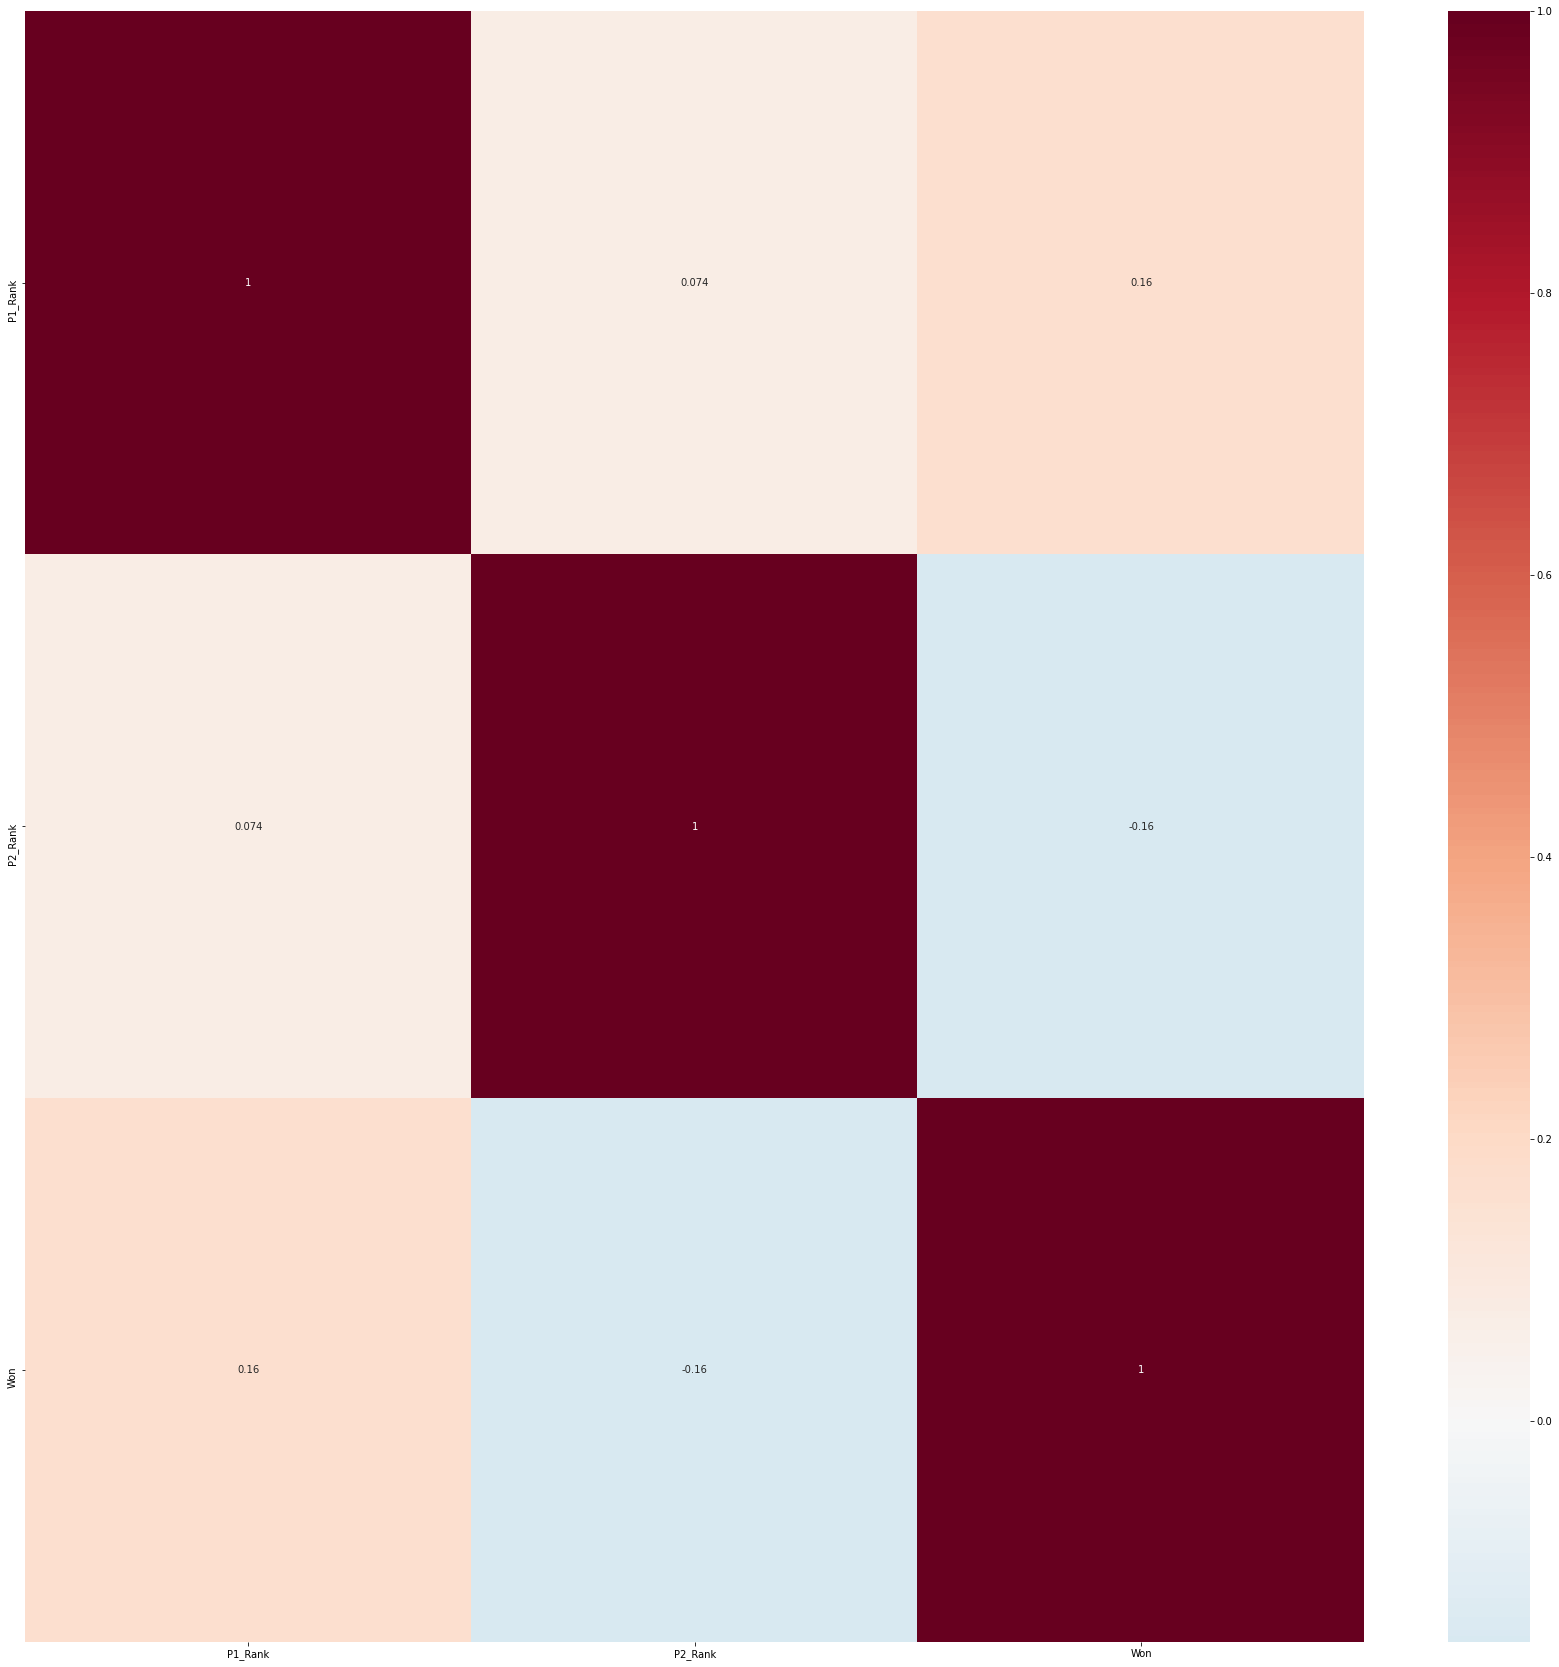

In [ ]:
# Heatmap 

plt.figure(figsize=(30,30))
correlation = data_M.corr()
sns.heatmap(correlation,  annot=True, cmap="RdBu_r", center =0);
plt.show()

#### Data Split and normalization

In [ ]:
# Split data and target 

DATA = data_M.drop('Won',axis=1)
TARGET = data['Won']

In [ ]:
# Split train/test

from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(DATA,TARGET,test_size=0.2,random_state=14)

In [ ]:
X_test.head(8)

,P1_Rank,P2_Rank
5783,385.0,12.0
14559,112.0,98.0
3355,55.0,16.0
3062,43.0,6.0
1929,13.0,2.0
3430,30.0,6.0
1938,1.0,3.0
12228,39.0,15.0


In [ ]:
# Dataset balancing

#from imblearn.over_sampling import RandomOverSampler 

#ros = RandomOverSampler(random_state=42)

#X_train, y_train = ros.fit_resample(X_train, y_train)

In [ ]:
# Normalization

#from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(random_state=0)
scaler=qt.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
#from sklearn import preprocessing

#scaler = preprocessing.StandardScaler().fit(X_train)
#X_train_scaled = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

## **Model Selection**

In [ ]:
from sklearn import linear_model

# Model training

clf=linear_model.LogisticRegression(random_state=10)
clf.fit(X_train_scaled,y_train)

# Model assessment

y_pred = clf.predict(X_test)

# Confusion Matrix 

cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)

# Score

print('\n''Score:',clf.score(X_test, y_test))

#Classification report

print('\n',classification_report(y_test, y_pred))


Classe prédite    1    2
Classe réelle           
1               958  518
2               530  980

Score: 0.6490288010716678

               precision    recall  f1-score   support

           1       0.64      0.65      0.65      1476
           2       0.65      0.65      0.65      1510

    accuracy                           0.65      2986
   macro avg       0.65      0.65      0.65      2986
weighted avg       0.65      0.65      0.65      2986



In [ ]:
# Prediction of a new instance

Xnew = [[52,212],[46,155],[100,16],[14,124],[105,49],[177,59],[43,275],[82,127],[121,45]]
Xnew = scaler.transform(Xnew)

# make a prediction

ypred = clf.predict(Xnew)

print("Prediction:",ypred)

ynew_prob = clf.predict_proba(Xnew)

print("Predicted=%s" % (ynew_prob))

Prediction: [1 1 2 1 2 2 1 1 2]
Predicted=[[0.71567698 0.28432302]
 [0.72244685 0.27755315]
 [0.22164418 0.77835582]
 [0.81418308 0.18581692]
 [0.33821287 0.66178713]
 [0.32316091 0.67683909]
 [0.7543143  0.2456857 ]
 [0.58684448 0.41315552]
 [0.30471272 0.69528728]]


In [ ]:
STOP

NameError: ignored

In [ ]:
# Weights

plt.figure(figsize=(7,7))

pd.Series(clf.coef_[0], X_train.columns).sort_values(ascending=False).plot(kind='barh');

In [ ]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train_scaled, y_train) 
y_pred = clf.predict(X_test) 
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)
print('\n''Score:',clf.score(X_test, y_test))
print('\n',classification_report(y_test, y_pred))

In [ ]:
from sklearn import ensemble

clf = ensemble.RandomForestClassifier(n_jobs = -1, random_state = 321)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)
print('\n''Score:',clf.score(X_test, y_test))
print('\n',classification_report(y_test, y_pred))

In [ ]:

from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion="entropy",max_depth=3,random_state=123)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)
print('\n''Score:',clf.score(X_test, y_test))
print('\n',classification_report(y_test, y_pred))

In [ ]:
# Features importance

from sklearn.tree import plot_tree

plt.figure(figsize=(15,12))
plot_tree(clf, feature_names = X_train.columns.tolist(), filled=True); #proportion=True

In [ ]:
# 3 main features

feat_importances = pd.Series(clf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(3).plot(kind = 'barh');

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Model training

clf = LinearDiscriminantAnalysis()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)
print('\n''Score:',clf.score(X_test, y_test))
print('\n',classification_report(y_test, y_pred))

In [ ]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

clf = QuadraticDiscriminantAnalysis()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)
print('\n''Score:',clf.score(X_test, y_test))
print('\n',classification_report(y_test, y_pred))

In [ ]:
from lightgbm.sklearn import LGBMClassifier

clf = LGBMClassifier()
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test)
cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)
print('\n''Score:',clf.score(X_test, y_test))
print('\n',classification_report(y_test, y_pred))

# **TESTS / WORK IN PROGRESS** 

## ARTHUR

Regression logistique

In [ ]:
#from sklearn import linear_model
#df_RL=data_M
#df_RL=df_RL.drop('index', axis=1)
#df_RL=df_RL.drop('Date', axis=1)
#df_RL=df_RL.drop('P1', axis=1)
#df_RL=df_RL.drop('P2', axis=1)
#df_RL.Won=df_RL['Won'].apply(lambda x: 0 if x ==1 else 1)

#DATA = df_RL.drop('Won',axis=1)
#TARGET = df_RL['Won']

#from sklearn.model_selection import train_test_split

#X_train,X_test,y_train,y_test=train_test_split(DATA,TARGET,test_size=0.2)


#clf = linear_model.LogisticRegression(C = 1.0)
#clf.fit(X_train, y_train)

In [ ]:
#y_pred = clf.predict(X_test)

# Calcul de la matrice de confusion 

## Méthode 1 : à l'aide de sklearn

#from sklearn.metrics import confusion_matrix 

#cm = confusion_matrix(y_test,y_pred)
#print(cm)

In [ ]:
#probs = clf.predict_proba(X_test)
#probs

In [ ]:
#url1 = 'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/Match.csv'
#match = pd.read_csv(url1)
#url2 = 'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/Player.csv'
#player = pd.read_csv(url2)
#url3 = 'https://raw.githubusercontent.com/GuillaumeRouja/2021-Tennis_Bet/main/Data/Stats.csv'
#stats = pd.read_csv(url3)

In [ ]:
#match.head()

In [ ]:
#player.head()

In [ ]:
#player.info()

In [ ]:
#stats.head()

## GUILLAUME

**LOGISTIC REGRESSION OPTIMIZATION**

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(DATA,TARGET,test_size=0.2,random_state=10)

scaler = preprocessing.StandardScaler()  # Normalization
selector = SelectKBest()   # Best features selection
lr = LogisticRegression()               

pipe = Pipeline([ ('scaling', scaler), 
                 ('selection', selector),      
                 ('model', lr)])           

param_grid = {
    'selection__k' : [1, 2, 3, 4, 5, 'all'],  
    'model__solver' : ['lbfgs', 'liblinear'], 
    'model__C': [10**(i) for i in range(-4,3)]    
}

grid = GridSearchCV(estimator = pipe, param_grid = param_grid, cv = 5, iid = True) # GridSearchCV instantiation

grid.fit(X_train,y_train)  

print(grid.best_params_) # Best parameters
print(grid.best_score_) # Best cross validation score

# Model assessment

y_pred = grid.predict(X_test)

# Confusion Matrix 

cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)

# Score

print('\n''Score:',grid.score(X_test, y_test))

#Classification report

print('\n',classification_report(y_test, y_pred))


In [ ]:
#Arthur Courbe ROC



**SVC OPTIMIZATION**

In [ ]:
#X_train,X_test,y_train,y_test=train_test_split(DATA,TARGET,test_size=0.2,random_state=10)

#scaler = QuantileTransformer()  # Normalization
#SVM = svm.SVC()             

#pipe = Pipeline([ ('scaling', scaler),    
                 #('model', SVM)])           

#param_grid = {
    #'model__kernel' : ['rbf', 'linear'], 
    #'model__C': [10**(i) for i in range(-4,3)]   
#}

#grid = GridSearchCV(estimator = pipe, param_grid = param_grid, cv = 5, iid = True) # GridSearchCV instantiation

#grid.fit(X_train,y_train)  

#print(grid.best_params_) # Best parameters
#print(grid.best_score_) # Best cross validation score

# Model assessment

#y_pred = grid.predict(X_test)

# Confusion Matrix 

#cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
#print(cm)

# Score

#print('\n''Score:',grid.score(X_test, y_test))

#Classification report

#print('\n',classification_report(y_test, y_pred))

**LINEAR DISCRIMINANT ANALYSIS OPTIMISATION**

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(DATA,TARGET,test_size=0.2,random_state=10)

#scaler = StandardScaler()
scaler = QuantileTransformer()  # Normalization
selector = SelectKBest()   # Best features selection
ld = LinearDiscriminantAnalysis()            

pipe = Pipeline([ ('scaling', scaler), 
                 ('selection', selector),      
                 ('model', ld)])           

param_grid = {
    'selection__k' : [4, 5, 'all'],  
    'model__solver' : ['svd', 'lsqr', 'eigen']   
}

grid = GridSearchCV(estimator = pipe, param_grid = param_grid, cv = 5, iid = True) # GridSearchCV instantiation

grid.fit(X_train,y_train)  

print(grid.best_params_) # Best parameters
print(grid.best_score_) # Best cross validation score

# Model assessment

y_pred = grid.predict(X_test)

# Confusion Matrix 

cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)

# Score

print('\n''Score:',grid.score(X_test, y_test))

#Classification report

print('\n',classification_report(y_test, y_pred))

**LGBM OPTIMZATION**

In [ ]:
#!pip install optuna

In [ ]:
#import optuna

#def objective(trial):

  #X_train,X_test,y_train,y_test=train_test_split(DATA,TARGET,test_size=0.2,random_state=10)

  #scaler = QuantileTransformer()  # Normalization
  #selector = SelectKBest()   # Best features selection
  #lgbm = LGBMClassifier()           

  #pipe = Pipeline([ ('scaling', scaler), 
                 #('selection', selector),      
                 #('model', lgbm)])           

  #param_grid = {
    #'selection__k' : [4, 5, 'all'],  
    #'model__max_depth' : trial.suggest_int("model__max_depth",2, 6),   
    #'model__learning_rate' : trial.suggest_loguniform("model__learning_rate", 1e-4, 10),
    #'model__n_estimators' : trial.suggest_int("n_estimators", 1, 400),
    #'model__min_split_gain' : trial.suggest_uniform("min_split_gain", 0, 1),
    #'model__device' : 'gpu'
  #}

  #grid = GridSearchCV(estimator = pipe, param_grid = param_grid, cv = 5, iid = True) # GridSearchCV instantiation

  #grid.fit(X_train,y_train)  

  #print(grid.best_params_) # Best parameters
  #print(grid.best_score_) # Best cross validation score

  #return grid.best_score_

#study = optuna.create_study(direction='minimize')
#study.optimize(objective, n_trials=100)  # Specify the number of trials.

# Model assessment

#y_pred = grid.predict(X_test)

# Confusion Matrix 

#cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
#print(cm)

# Score

#print('\n''Score:',grid.score(X_test, y_test))

#Classification report

#print('\n',classification_report(y_test, y_pred))

In [ ]:

X_train,X_test,y_train,y_test=train_test_split(DATA,TARGET,test_size=0.2,random_state=10)

scaler = QuantileTransformer()  # Normalization
selector = SelectKBest()   # Best features selection
lgbm = LGBMClassifier()           

pipe = Pipeline([ ('scaling', scaler),       
                 ('model', lgbm)])           

param_grid = { 
    'model__max_depth' : [19],   
    'model__learning_rate' : [0.295],
    'model__gamma':[0.8],
    'model__lambda':[0],
    'model__alpha':[2],
    'model__num_rounds':[300],
    'model__early_stop':[5],
  }

grid = GridSearchCV(estimator = pipe, param_grid = param_grid, cv = 5, iid = True) # GridSearchCV instantiation

grid.fit(X_train,y_train)  

print(grid.best_params_) # Best parameters
print(grid.best_score_) # Best cross validation score

# Model assessment

y_pred = grid.predict(X_test)

# Confusion Matrix 

cm = pd.crosstab(y_test, y_pred, rownames=['Classe réelle'], colnames=['Classe prédite'])
print(cm)

# Score

print('\n''Score:',grid.score(X_test, y_test))

#Classification report

print('\n',classification_report(y_test, y_pred))

In [ ]:

#n_col = len(data_M.columns) 

#fig, axs = plt.subplots(nrows = n_col)

#for variable, ax in zip(data_M.columns, axs):
    #sns.violinplot(x = 'Won', y = variable, data = data_M, ax = ax)
    #ax.set_title(variable)
    
    
#fig.set_size_inches(16, 300)

In [ ]:

# TO TEST - creation of dataframe columns in a cleaner way

#---------------------
#def some_func(x):
 # a = 1
  #b = 2
  #return a,b 

#df[['column1','column2']] = df.apply(some_func,axis=1, result_type ='expand')
#---------------------

In [ ]:



# EXPERIMENTS 2 # Grouping by classes

# Let's try divide the ATP rankings into 4 categories

#data['P1_Rank_classes']=pd.qcut(data['P1_Rank'],labels=[1,2,3,4],q=4)
#data['P2_Rank_classes']=pd.qcut(data['P2_Rank'],labels=[1,2,3,4],q=4)
#data["P1_Rank_classes"] = data["P1_Rank_classes"].astype('category')
#data["P1_Rank_classes"] = data["P1_Rank_classes"].cat.codes
#data["P2_Rank_classes"] = data["P2_Rank_classes"].astype('category')
#data["P2_Rank_classes"] = data["P2_Rank_classes"].cat.codes
#data.drop('P1_Rank',axis=1,inplace=True)
#data.drop('P2_Rank',axis=1,inplace=True)
#charges_classes = pd.qcut(df.total_charges, labels=[1,2,3,4,5,6,7,8]q=8)

# EXPERIMENTS 3 # Keep most frequent players in the dataset.

# Get those players

#most_frequent_P1 = data['P1'].value_counts()[:300].index.tolist()
#most_frequent_P2 = data['P2'].value_counts()[:300].index.tolist()

# Dataframe is filtered to only take the most productive players

#data=data[data['P1'].isin(most_frequent_P1)&data['P2'].isin(most_frequent_P2)]


# EXPERIMENT 4 # Create "Month variable"

#data['Month'] = data.Date
#data['Month'] = data.Month.apply(lambda x: x[:-3])
#data['Month'] = pd.to_datetime(data.Month)

In [ ]:
#import xgboost as xgb -> lgbm is preferred 

#X_train,X_test,y_train,y_test=train_test_split(DATA,TARGET,test_size=0.2,random_state=10)

# Variable encoding:
#y_train = [0 if x == 1 else 1 for x in y_train]
#y_test = [0 if x == 1 else 1 for x in y_test]

# Training parameters
#params = {'objective': 'binary:logistic', 'max_depth': 6}

# DMatrix preparation
#dtrain = xgb.DMatrix(X_train, label=y_train)
#dtest =  xgb.DMatrix(data = X_test, label = y_test)

# Model training
#clf = xgb.train(params, dtrain, 200)

# Model assessment

#probs = clf.predict(dtest)
#preds = [0 if x<0.5 else 1 for x in probs]

#print(classification_report(y_test, preds))

In [ ]:
# Validation croisée imbriquée (Nested CV) 

#from sklearn.model_selection import GridSearchCV, cross_val_score
#from sklearn.linear_model import LogisticRegression
#from sklearn.ensemble import RandomForestClassifier
#from sklearn.svm import SVC

#clf_lr = LogisticRegression (random_state=22, max_iter=2000)
#clf_rf = RandomForestClassifier (random_state=22)
#clf_svc = SVC (random_state=22)

#param_grid_lr  = {'solver': ['liblinear', 'lbfgs'],
                     #'C': np.logspace(-4,2,9)}

#param_grid_rf  = {'n_estimators': [10, 50, 100, 250, 500, 1000],
                     #'min_samples_leaf': [1, 3, 5],
                     #'max_features': ['sqrt', 'log2']}

#param_grid_svc = {'kernel': ['rbf'],'C': np.logspace(-4, 4, 9),'gamma': np.logspace(-4, 0, 4)},{'kernel': ['linear'],'C': np.logspace(-4, 4, 9)}
                     

#gridcvs = {}

#for pgrid, clf, name in zip((param_grid_lr,
                             #param_grid_rf, param_grid_svc),
                            #(clf_lr, clf_rf, clf_svc),
                            #('LogisticRegression', 'RF', 'SVM')):
    #gcv = GridSearchCV(clf,
                       #pgrid,
                       #cv=3,
                       #refit=True)
    #gridcvs[name] = gcv

#from sklearn.model_selection import StratifiedKFold

#outer_cv = StratifiedKFold(n_splits=3, shuffle=True)
#outer_scores = {}

#for name, gs in gridcvs.items():
    #nested_score = cross_val_score(gs, 
                                   #X_train, 
                                   #y_train, 
                                   #cv=outer_cv)
    #outer_scores[name] = nested_score
    #print(f'{name}: outer accuracy {100*nested_score.mean():.2f} +/- {100*nested_score.std():.2f}')

In [ ]:
#from skater.core.explanations import Interpretation
#from skater.model import InMemoryModel

#interpreter = Interpretation(X_train, feature_names=X_train.columns)

#def predict_xg(x):
   # return pd.DataFrame(clf.predict(xgb.DMatrix(x)))

#model = InMemoryModel(predict_xg, examples = X_train)


#plt.figure(figsize=(20,12))
                  
#plots = interpreter.feature_importance.plot_feature_importance(model, ascending=True);

#interpreter.partial_dependence.plot_partial_dependence(['P1_Elo'], model, grid_resolution=100,
                                                      # with_variance=True, figsize = (6, 4));

#import shap

#explainer = shap.TreeExplainer(clf)
#shap_values = explainer.shap_values(X_test)
#print('Expected Value:', explainer.expected_value)

#pd.DataFrame(shap_values).head()

#shap.summary_plot(shap_values, X_test, plot_type="bar")
#shap.summary_plot(shap_values, X_test)

## WILL